### Mentoria DSA

O projeto consiste em elaborar um modelo de regressão com a finalidade de prever o valor dos imóveis, dentro do estado de São Paulo. Após realizar uma série de análises exploratória, em scripts anteriores, esse script tem como objetivo a criação do modelo de Machine Learning.
***
Houve uma modificação nos valores da variável "property_type", representado abaixo:
- 1-apartment;
- 2-house;
- 3-store;
- 4-PH;
***

In [1]:
# importação dos pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Versões dos pacotes usadas neste Jupyter Notebook
!python --version
%reload_ext watermark
%watermark -a "Mentoria DSA" --iversions

Python 3.7.3
Author: Mentoria DSA

matplotlib: 3.0.3
seaborn   : 0.9.0
pandas    : 0.24.2
numpy     : 1.16.2



In [3]:
# Carregamento do dataset
df = pd.read_csv("../../data/df_filter.csv")

# preenchimento do número de quartos, por cidade
df["rooms"] = round(df["rooms"].fillna(df.groupby("Cidade")["rooms"].\
                                       transform("mean")))

# remover restos de valores NaN
df.dropna(subset=["rooms"], inplace=True)

# transformar variável para o tipo int
df["rooms"] = df["rooms"].astype(int)

# removendo registros de imóveis com mais de 5 quartos
df = df[df["rooms"] < 5]

# # preenchimento do valor m2, por cidade
df["price_per_m2"] = df["price_per_m2"].fillna(df.groupby("Cidade")["price_per_m2"].\
                                       transform("mean"))

# remover restos de valores NaN
df.dropna(subset=["price_per_m2"], inplace=True)

# removendo outliers com altos valores na variável "surface_covered_in_m2"
df = df[df['surface_covered_in_m2'] < 500]

# removendo outliers com altos valores na variável "price_per_m2"
df = df[df['price_per_m2'] < 18000]

In [4]:
df.head()

created_on  property_type     place_name     price  \
634  2013-09-04              1   Higienópolis  960000.0   
635  2013-09-04              1       Perdizes  900000.0   
636  2013-09-04              1   Higienópolis  420000.0   
637  2013-09-04              1       Perdizes  766000.0   
638  2013-09-04              1  Santa Cecília  615000.0   

     price_aprox_local_currency  price_aprox_usd  surface_covered_in_m2  \
634                   969211.52        303011.17                  109.0   
635                   908635.80        284072.97                  130.0   
636                   424030.02        132567.38                   40.0   
637                   773350.02        241777.66                  104.0   
638                   620901.13        194116.53                   71.0   

     price_usd_per_m2  price_per_m2  rooms     Estado     Cidade  \
634       2779.918991   8807.339450      3  São Paulo  São Paulo   
635       2185.176692   6923.076923      3  São Paulo  São Paulo   
636       3314.184500  10500.000000      1  São Paulo  São Paulo   
637       2324.785192   7365.384615      3  São Paulo  São Paulo   
638       2734.035634   8661.971831      3  São Paulo  São Paulo   

            Bairro  
634   Higienópolis  
635       Perdizes  
636   Higienópolis  
637       Perdizes  
638  Santa Cecília

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


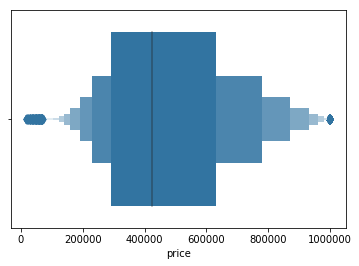

In [5]:
# identificação dos outliers do preços
sns.boxenplot(df['price'])

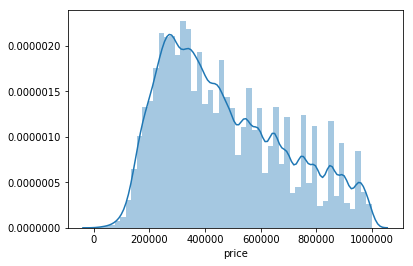

In [6]:
# Análise da distribuição da variável target
sns.distplot(df["price"]);

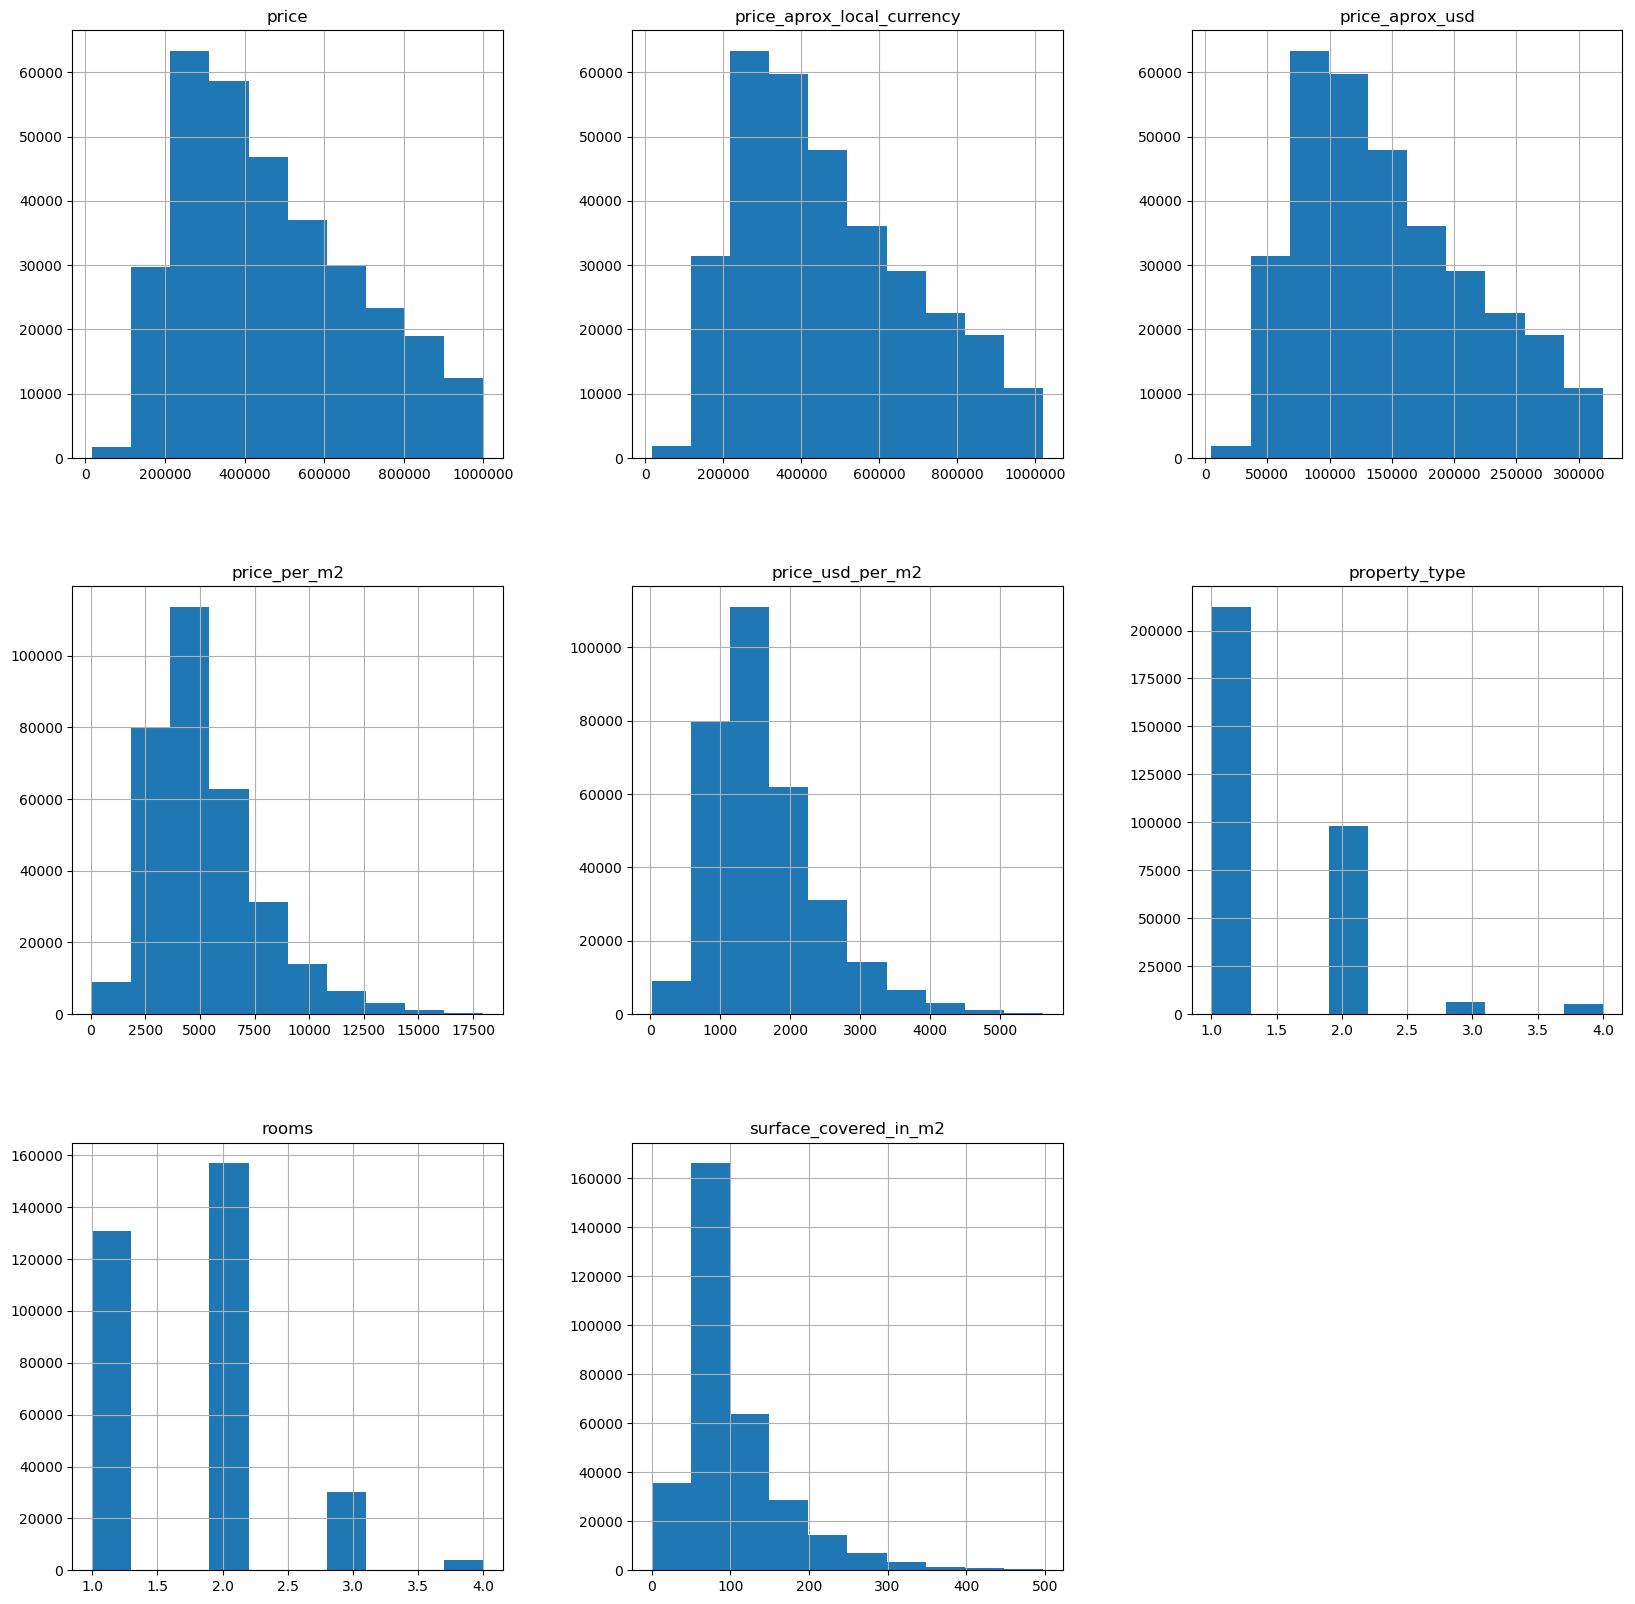

In [7]:
#análise do histograma
plt.style.use("default")
df.hist(layout=(3,3), figsize= (20,20))
plt.show()

In [8]:
# Distribuição entre os tipos de imóveis
df["property_type"].value_counts()

1    212376
2     97985
3      6328
4      5340
Name: property_type, dtype: int64

Os tipos de imóveis "store" e "PH" tornaram-se insignificantes para a elaboração do modelo, devido ao baixo número de registros para esses tipos de imóveis. Para tanto, serão removidos, ficando somente as categorias "apartment" e "house"

In [9]:
df = df[(df.property_type == 1) | (df.property_type == 2)]

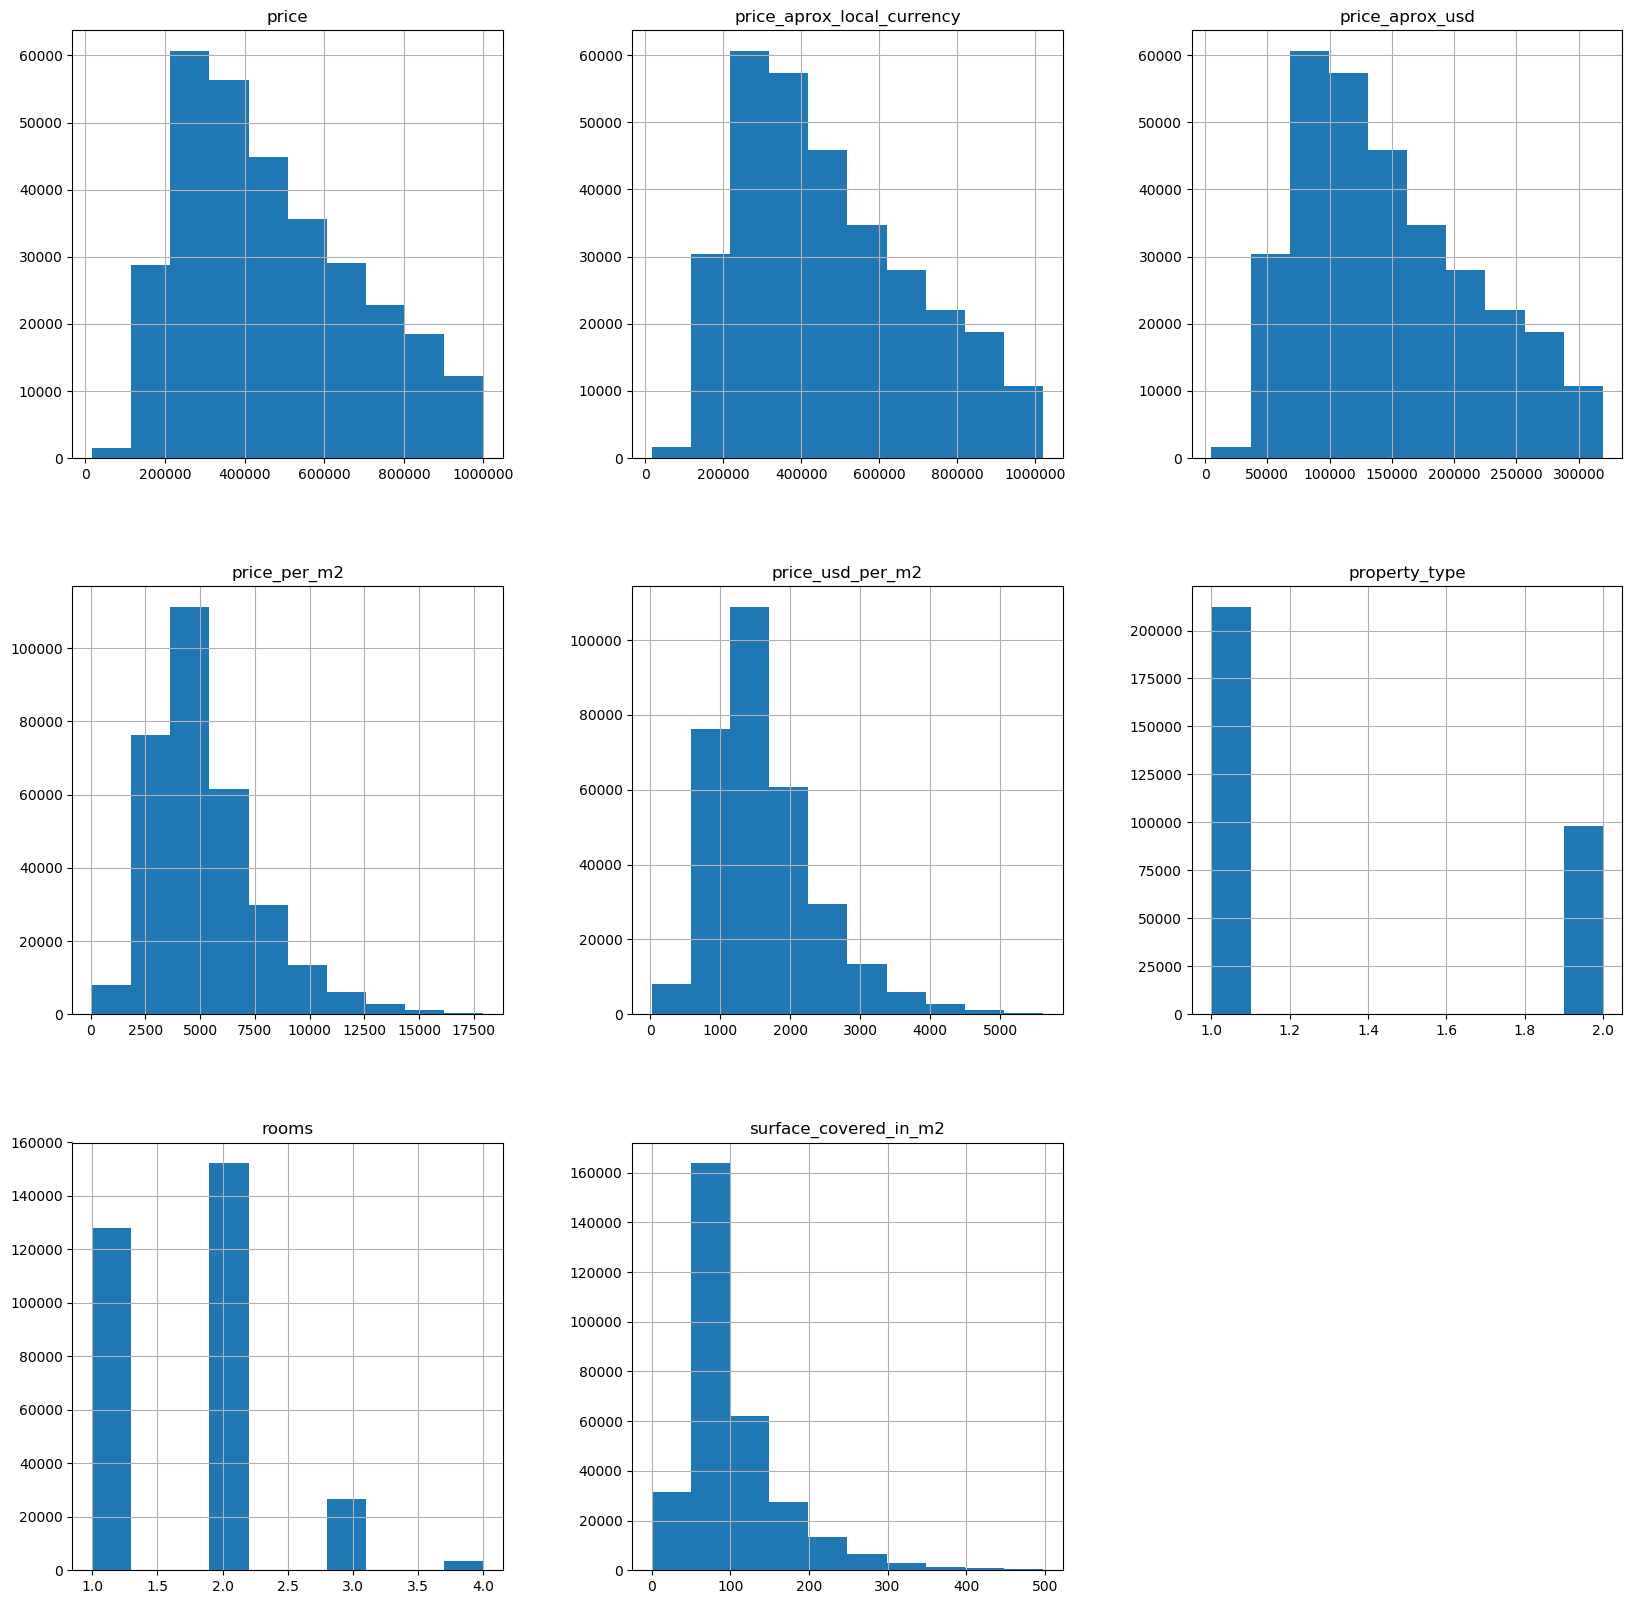

In [10]:
#análise do histograma
plt.style.use("default")
df.hist(layout=(3,3), figsize= (20,20))
plt.show()

In [11]:
# remoção das variáveis com alto grau de correlação
del df['price_aprox_local_currency']
del df['price_aprox_usd']
del df['price_usd_per_m2']
del df['Bairro']

In [12]:
# acrescentando "property_type" às variáveis quantitativas
quantitative = ['surface_covered_in_m2', 'price_per_m2', 'rooms', 'property_type', 'price']

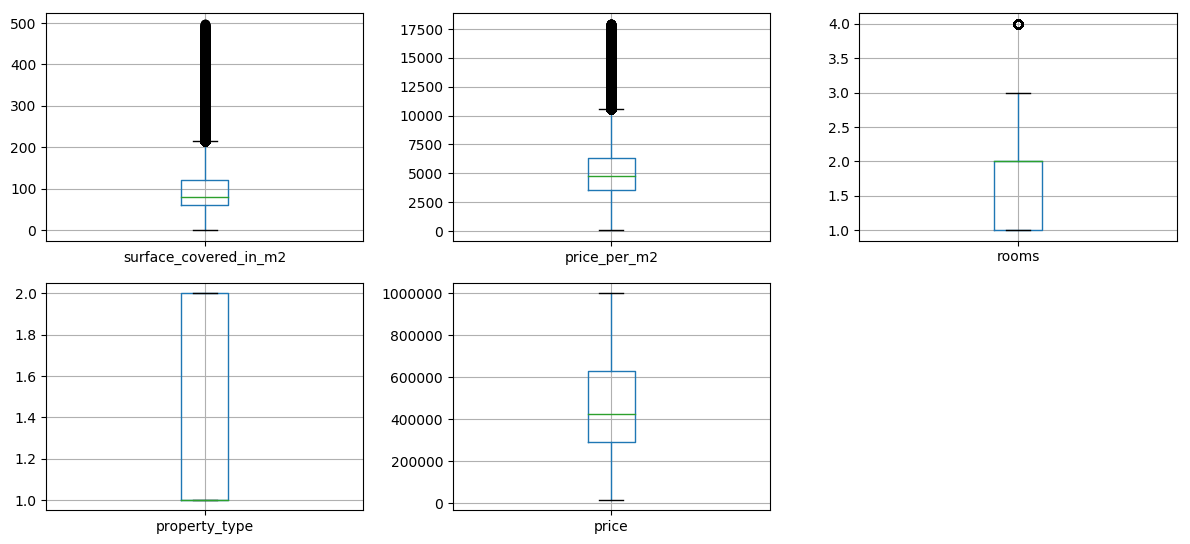

In [13]:
# Boxplot das variáveis somente para o Estado de São Paulo

# tamanho da área de plotagem

fig = plt.figure(figsize=(12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(quantitative):
    plt.subplot(3, 3, i+1);
    df.boxplot(col);
    plt.tight_layout()

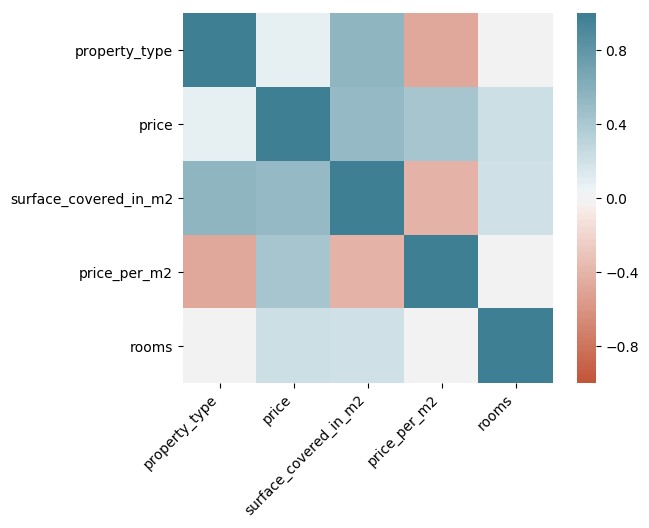

In [14]:
# Correlação entre as variáveis quantitativas de forma gráfica

# Gráfico de correlação com a tratativa para histograma
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Criação do Modelo

Métricas utilizadas nesse scripo: MSE e R^2

MSE - Mean Squared Error -> similar ao MAE, fornece a magnitude do erro do modelo;
- quanto maior, pior o modelo;
- ao extrair a raiz quadrada do MSE converte-se as unidades de volta ao original, o que pode ser útil para descrição e apresentação. Isso é chamado de RMSE (Root Mean Squared Error);

MAE - Mean Absolute Error
- é a soma da diferença absoluta entre previsões e valores reais;
- fornece uma ideia de quão erradas estão as previsões realizadas;
- valor igual a 0 indica que não há erro, sendo a previsão perfeita;

R^2
- essa métrica fornece uma indicação do nível de previsão das previsões em relação aos valores observados;
- também chamado de coeficiente de determinação;
- valores entre 0 e 1, sendo 0 o valor ideal;


### Linear Regression

In [15]:
# resultado utilizando a métrica R^2
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [16]:
# criação do modelo com os dados tratados
df_model1 = df[quantitative]

# transformando os dados em array
array = df_model1.values

# separando o array em componentes de input e outout
X = array[:,0:4]
Y = array[:,4]

# divisão dos dados de treino e de teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# criação do modelo
modelo1 = LinearRegression()

# treinando o modelo
modelo1.fit(X_train, Y_train)

# previsões com o modelo criado
Y_pred1 = modelo1.predict(X_test)

In [17]:
mse1 = mean_absolute_error(Y_test, Y_pred1)
print("O MSE encontrado: ", mse1)

O MSE encontrado:  71320.1414683458


In [18]:
r2_Score1 = r2_score(Y_test, Y_pred1)
print("O R2 Score encontrado: ", r2_Score1)

O R2 Score encontrado:  0.7599021958737009


### KNN

In [19]:
# importação dos módulos
from sklearn.neighbors import KNeighborsRegressor

In [20]:
# criação do modelo com os dados tratados
df_model1 = df[quantitative]

# transformando os dados em array
array = df_model1.values

# separando o array em componentes de input e outout
X = array[:,0:4]
Y = array[:,4]

# divisão dos dados de treino e de teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# criação do modelo
modelo2 = KNeighborsRegressor()

# treinando o modelo
modelo2.fit(X_train, Y_train)

# previsões com o modelo criado
Y_pred2 = modelo2.predict(X_test)

In [21]:
# Cálculo das métricas
mse2 = mean_absolute_error(Y_test, Y_pred2)
r2_Score2 = r2_score(Y_test, Y_pred2)

# Resultado das métricas
print("O MSE encontrado: ", mse2)
print("O R2 Score encontrado: ", r2_Score2)

O MSE encontrado:  4387.985452060145
O R2 Score encontrado:  0.9893752489447424


### Decision Tree

In [22]:
# importação dos módulos
from sklearn.tree import DecisionTreeRegressor

In [23]:
# criação do modelo com os dados tratados
df_model1 = df[quantitative]

# transformando os dados em array
array = df_model1.values

# separando o array em componentes de input e outout
X = array[:,0:4]
Y = array[:,4]

# divisão dos dados de treino e de teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# criação do modelo
modelo3 = DecisionTreeRegressor()

# treinando o modelo
modelo3.fit(X_train, Y_train)

# previsões com o modelo criado
Y_pred3 = modelo3.predict(X_test)

In [24]:
# Cálculo das métricas
mse3 = mean_absolute_error(Y_test, Y_pred3)
r2_Score3 = r2_score(Y_test, Y_pred3)

# Resultado das métricas
print("O MSE encontrado: ", mse3)
print("O R2 Score encontrado: ", r2_Score3)

O MSE encontrado:  2126.4476479708915
O R2 Score encontrado:  0.9916687737193343


### SVM

In [25]:
# # importação dos módulos
# from sklearn.svm import SVR

In [26]:
# # criação do modelo com os dados tratados
# df_model1 = df[quantitative]

# # transformando os dados em array
# array = df_model1.values

# # separando o array em componentes de input e outout
# X = array[:,0:4]
# Y = array[:,4]

# # divisão dos dados de treino e de teste
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

# # criação do modelo
# modelo4 = SVR()

# # treinando o modelo
# modelo4.fit(X_train, Y_train)

# # previsões com o modelo criado
# Y_pred4 = modelo4.predict(X_test)

In [27]:
# # Cálculo das métricas
# mse4 = mean_absolute_error(Y_test, Y_pred4)
# r2_Score4 = r2_score(Y_test, Y_pred4)

# # Resultado das métricas
# print("O MSE encontrado: ", mse4)
# print("O R2 Score encontrado: ", r2_Score4)

In [32]:
# Salvando o melhor modelo em arquivo .txt
np.savetxt("../../data/linearregression.csv", Y_pred3, delimiter=",")